1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


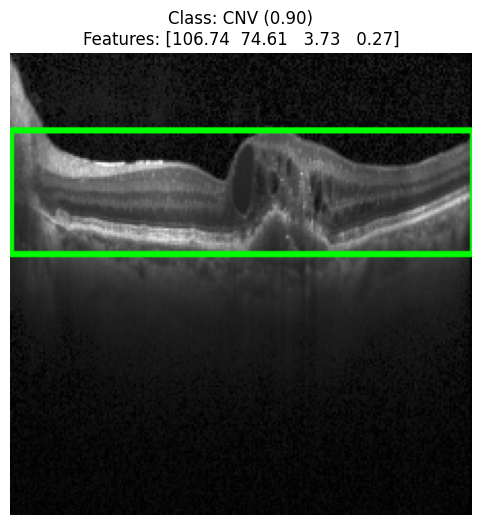

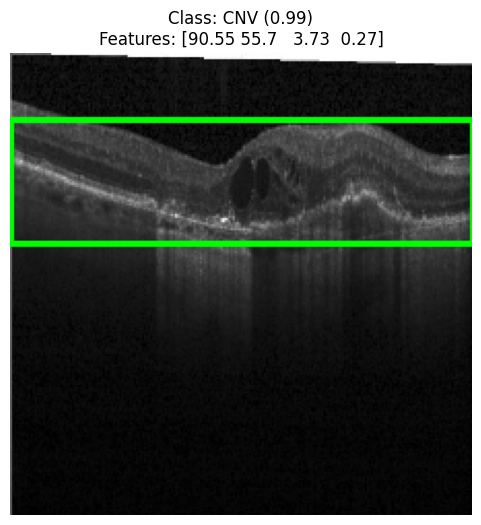

Predicted: CNV, Confidence: 0.99, Features: [np.float64(90.55119047619047), np.float64(55.69819073330586), 3.7333333333333334, 0.26785714285714285]


In [29]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Load the model
model = tf.keras.models.load_model('/content/CNN_Blocks_Model_Scratch_Bounded-Box_Process.h5')
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# ---------- ROI Processing Helpers ----------
def preprocess_image(img):
    img = cv2.resize(img, (224, 224))
    img = cv2.fastNlMeansDenoising(img, h=15)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    img = clahe.apply(img)

    blur = cv2.GaussianBlur(img, (3, 3), 0)
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    img = cv2.filter2D(blur, -1, sharpen_kernel)
    return img

def detect_roi_by_edge_density(img_gray):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    row_sum = np.sum(magnitude, axis=1)

    window_height = 60
    max_density = 0
    best_top = 0
    for top in range(0, len(row_sum) - window_height):
        density = np.sum(row_sum[top:top + window_height])
        if density > max_density:
            max_density = density
            best_top = top

    roi_box = (0, best_top, img_gray.shape[1], window_height)
    return roi_box

def extract_features(img, roi_box):
    x, y, w, h = roi_box
    roi = img[y:y+h, x:x+w]
    mean_val = np.mean(roi)
    std_val = np.std(roi)
    aspect_ratio = w / h
    area_ratio = (w * h) / (img.shape[0] * img.shape[1])
    return [mean_val, std_val, aspect_ratio, area_ratio]

# ---------- Combined Prediction + ROI Flow ----------
def predict_and_visualize(image_path):
    # Load grayscale for ROI
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if gray_img is None:
        print(f"Error loading image: {image_path}")
        return

    processed_gray = preprocess_image(gray_img)
    roi_box = detect_roi_by_edge_density(processed_gray)
    features = extract_features(processed_gray, roi_box)

    # Draw ROI on color image for visualization
    img_rgb = cv2.imread(image_path)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    x, y, w, h = roi_box
    img_rgb_roi = img_rgb.copy()
    cv2.rectangle(img_rgb_roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Prepare image for prediction
    model_input = cv2.cvtColor(processed_gray, cv2.COLOR_GRAY2RGB)
    model_input = model_input.astype('float32') / 255.0
    model_input = np.expand_dims(model_input, axis=0)

    # Predict
    prediction = model.predict(model_input)
    class_idx = np.argmax(prediction)
    class_name = class_names[class_idx]
    confidence = np.max(prediction)

    # Plot result
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_rgb_roi, cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {class_name} ({confidence:.2f})\nFeatures: {np.round(features, 2)}")
    plt.axis('off')
    plt.show()

    return class_name, confidence, features

# ----------- Example Usage ----------- #
image_path = '/content/CNV-103044-1.jpeg'
class_name, conf, feats = predict_and_visualize(image_path)
print(f"Predicted: {class_name}, Confidence: {conf:.2f}, Features: {feats}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


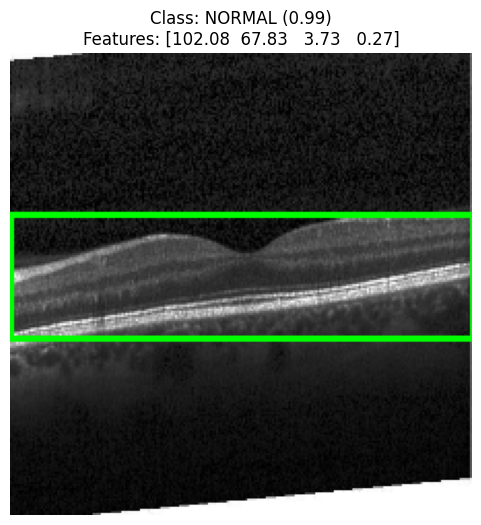

Predicted: NORMAL, Confidence: 0.99, Features: [np.float64(102.07775297619048), np.float64(67.83108273374262), 3.7333333333333334, 0.26785714285714285]


In [22]:
image_path = '/content/NORMAL-12494-2.jpeg'
class_name, conf, feats = predict_and_visualize(image_path)
print(f"Predicted: {class_name}, Confidence: {conf:.2f}, Features: {feats}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


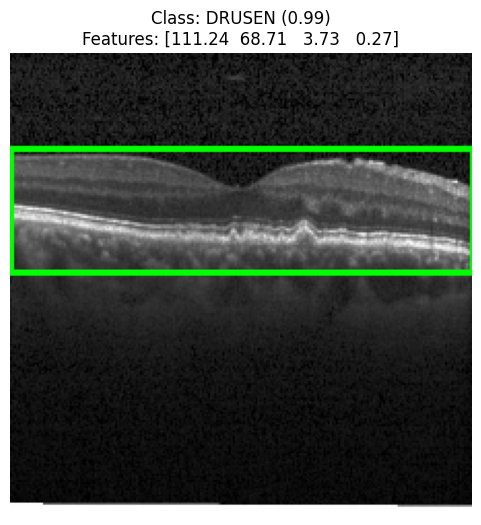

Predicted: DRUSEN, Confidence: 0.99, Features: [np.float64(111.24278273809524), np.float64(68.71178634941604), 3.7333333333333334, 0.26785714285714285]


In [23]:
image_path = '/content/DRUSEN-228939-1.jpeg'
class_name, conf, feats = predict_and_visualize(image_path)
print(f"Predicted: {class_name}, Confidence: {conf:.2f}, Features: {feats}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


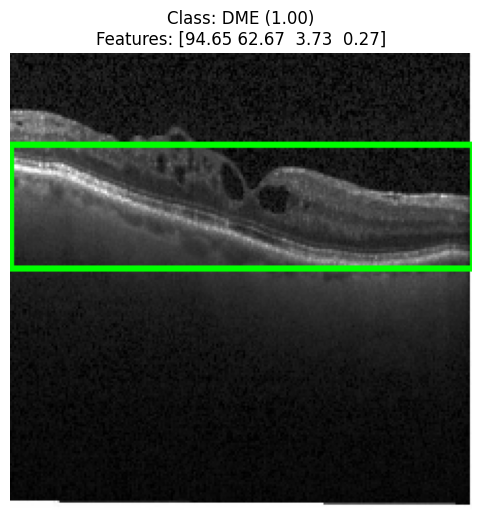

Predicted: DME, Confidence: 1.00, Features: [np.float64(94.65096726190477), np.float64(62.6677247611797), 3.7333333333333334, 0.26785714285714285]


In [24]:
image_path = '/content/DME-30521-1.jpeg'
class_name, conf, feats = predict_and_visualize(image_path)
print(f"Predicted: {class_name}, Confidence: {conf:.2f}, Features: {feats}")

In [26]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00


In [34]:
from PIL import Image
import io

def gradio_interface(image):
    # Save the uploaded image temporarily
    with tempfile.NamedTemporaryFile(delete=False, suffix=".jpg") as tmp:
        image.save(tmp.name)
        image_path = tmp.name

    # Call your existing function
    class_name, conf, feats = predict_and_visualize(image_path)

    # Recreate processed image with ROI box (as in your function)
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    processed_gray = preprocess_image(gray_img)
    roi_box = detect_roi_by_edge_density(processed_gray)
    img_rgb = cv2.imread(image_path)
    img_rgb = cv2.resize(img_rgb, (224, 224))
    x, y, w, h = roi_box
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Convert BGR (OpenCV) to RGB for PIL
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)

    os.unlink(image_path)  # Clean up temp file

    result_text = f"Class: {class_name}\nConfidence: {conf:.2f}\nFeatures: {np.round(feats, 2)}"
    return pil_img, result_text

# Gradio UI
gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil", label="Upload Retinal Image"),
    outputs=[
        gr.Image(type="pil", label="Image with ROI"),
        gr.Textbox(label="Prediction Result")
    ],
    title="Retinal Disease Classifier with ROI Features",
    description="Upload an OCT retinal image to classify and visualize region of interest (ROI) with extracted features."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8839005c3f438f31cf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
